# Классификация альбомов по жанру

## Описание проекта

**Основная задача:**
Разработать модель машинного обучения, способную определять жанр музыкального альбома по изображению его обложки. Модель должна распознавать различные жанры исходя из визуальных особенностей обложек.

**Данные:**
Набор данных состоит из изображений в формате PNG, организованных по жанрам и упакованных в zip-архивы. Каждый архив соответствует определенному музыкальному жанру и содержит папку с изображениями обложек.

**Метрики:**
Для оценки качества классификации рекомендованы метрики Accuracy, Precision, Recall и F1-score. В рамках исследования возможно предложение и тестирование альтернативных метрик для более глубокого анализа модели.

## Загрузка и исследование данных

In [5]:
import cv2
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
import numpy as np
import os
import pandas as pd
from PIL import Image
import re
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import time
from tqdm import tqdm

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!7z x /content/drive/MyDrive/album_photo.zip -o. -y


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 1258239357 bytes (1200 MiB)

Extracting archive: /content/drive/MyDrive/album_photo.zip
 52% 4096 Open              --
Path = /content/drive/MyDrive/album_photo.zip
Type = zip
Physical Size = 1258239357

  0%      1% 116 - album_photo/pop/611f590b-879f-42d2-8996-06cbc21fb831.png                                                                     1% 145 - album_photo/pop/b5f953d6-5de4-4879-80ac-5d17b720c814.png

In [8]:
DATA_PATH = './album_photo'

In [9]:
genres = ['anime',
          'black metal',
          'classical',
          'country',
          'disco',
          'edm',
          'jazz',
          'pop',
          'rap',
          'reggae'
          ]

album_dict = {'count' : [len(os.listdir(os.path.join(DATA_PATH, 'anime'))),
                         len(os.listdir(os.path.join(DATA_PATH, 'black metal'))),
                         len(os.listdir(os.path.join(DATA_PATH, 'classical'))),
                         len(os.listdir(os.path.join(DATA_PATH, 'country'))),
                         len(os.listdir(os.path.join(DATA_PATH, 'disco'))),
                         len(os.listdir(os.path.join(DATA_PATH, 'edm'))),
                         len(os.listdir(os.path.join(DATA_PATH, 'jazz'))),
                         len(os.listdir(os.path.join(DATA_PATH, 'pop'))),
                         len(os.listdir(os.path.join(DATA_PATH, 'rap'))),
                         len(os.listdir(os.path.join(DATA_PATH, 'reggae')))
                        ]
              }
df = pd.DataFrame(data=album_dict, index=genres)

In [10]:
display(df)

,count
anime,1189
black metal,450
classical,955
country,1486
disco,468
edm,719
jazz,821
pop,803
rap,328
reggae,581


Имеется 10 жанров, пустых жанров нет

In [11]:
print('Общий размер датасета:', df['count'].sum(), "изображений")

Общий размер датасета: 7800 изображений


Изучение данных изображений:

In [12]:
def show_images(image_paths):
  """
  Выводит изображения из списка путей к изображениям.

  Параметры:
  image_paths (list): Список строк, содержащих пути к изображениям.

  Возвращаемое значение:
  None
  """
  fig, axs = plt.subplots(1, len(image_paths), figsize=(15, 3))
  for i, img_path in enumerate(image_paths):
    img = Image.open(img_path)
    axs[i].imshow(img)
    axs[i].axis('off')
  plt.show()

Обложка жанра "anime":


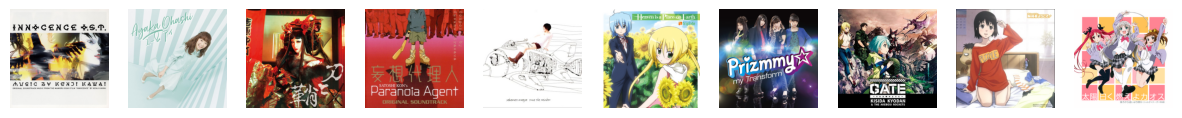

Обложка жанра "black metal":


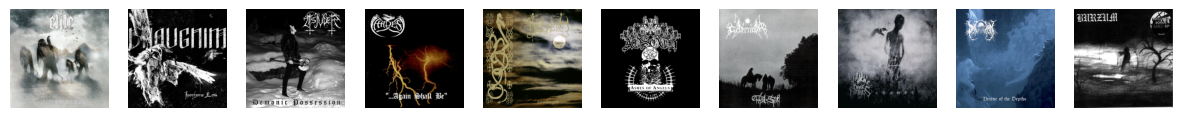

Обложка жанра "classical":


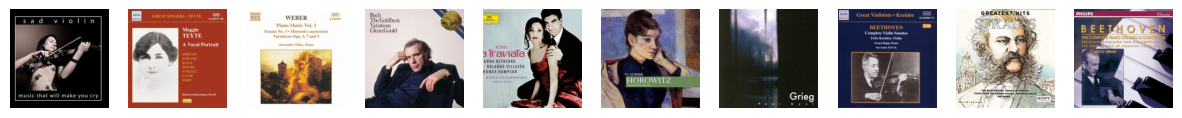

Обложка жанра "country":


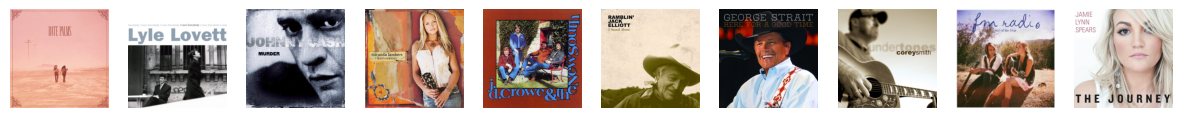

Обложка жанра "disco":


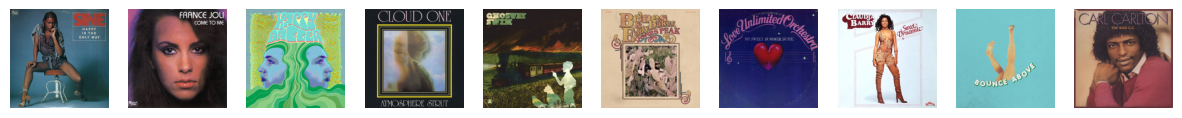

Обложка жанра "edm":


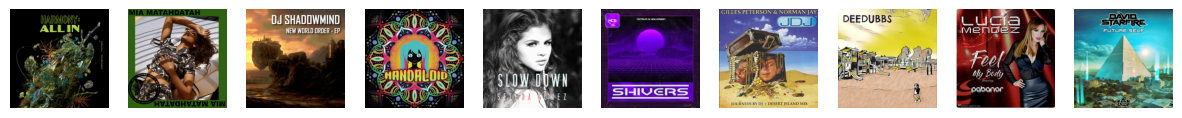

Обложка жанра "jazz":


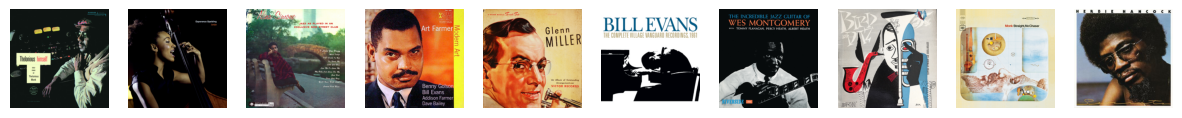

Обложка жанра "pop":


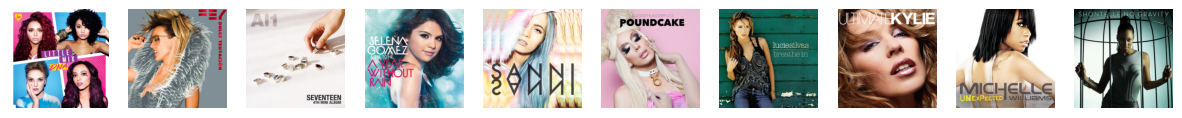

Обложка жанра "rap":


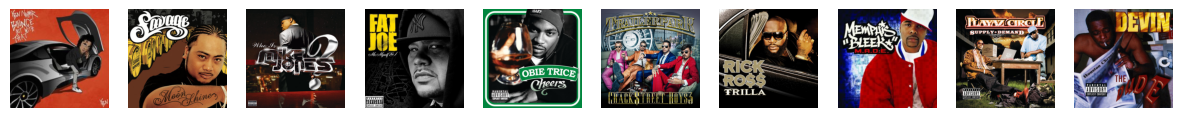

Обложка жанра "reggae":


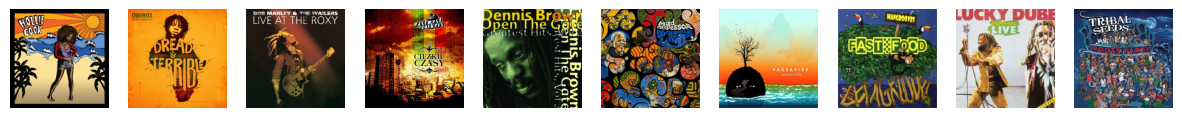

In [13]:
num_imgs_per_genre = 10

for genre in genres:
  genre_path = os.path.join(DATA_PATH, genre)
  image_files = os.listdir(genre_path)[:num_imgs_per_genre]
  image_paths = [os.path.join(genre_path, img) for img in image_files]
  print(f'Обложка жанра "{genre}":')
  show_images(image_paths)

In [14]:
print(genre_path)

./album_photo/reggae


Выведены первые 10 изображений каждого из жанров. Данные выглядят нормально, несоответствий альбомов жанрам на первый взгляд не выявлено.

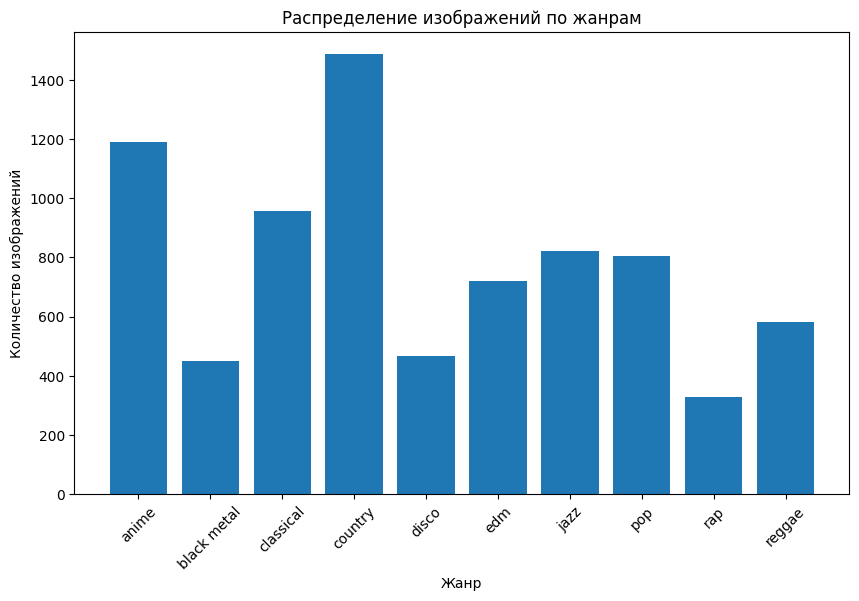

In [15]:
plt.figure(figsize=(10, 6))
plt.bar(genres, df['count'])
plt.xlabel('Жанр')
plt.ylabel('Количество изображений')
plt.title('Распределение изображений по жанрам')
plt.xticks(rotation=45)
plt.show()

Наибольшее количество обложек имеется в стиле `country`, наименьшее - в `black metal`

In [16]:
statistics = df['count'].describe()
print("Описательная статистика для количества изображений:")
print(statistics)

Описательная статистика для количества изображений:
count      10.0000
mean      780.0000
std       357.8364
min       328.0000
25%       496.2500
50%       761.0000
75%       921.5000
max      1486.0000
Name: count, dtype: float64


Большая часть жанров содержит от 500 до ~950 обложек, в среднем 780 фото в каждом жанре

## Подготовка датасета

Класс для обработки изображений и манипуляций с ними:

In [17]:
class CoverDataset:
    def __init__(self, root_path: str, transform=None, target_transform=None):
        self.root_path = root_path
        self.classes = os.listdir(root_path)
        classes = []
        for x in self.classes:
          if x[0] != '.':
            classes.append(x)
        self.classes = classes
        self.file_list = []
        self.transform = transform
        for index, genre in enumerate(self.classes):
            genre_path = os.path.join(root_path, genre)
            for image_name in os.listdir(genre_path):
                img_path = os.path.join(genre_path, image_name)
                self.file_list.append((img_path, index))
                # image = datasets.folder.default_loader(img_path)


    def __len__(self):
      return len(self.file_list)


    def __getitem__(self, index):
        img_path, genre = self.file_list[index]
        image = Image.open(img_path).convert('RGB')
        label = self.classes[genre]
        if self.transform:
            image = self.transform(image)
        return image, genre, label


    def get_image_by_index(self, index):
        img_path, _ = self.file_list[index]
        image = Image.open(img_path).convert('RGB')
        return image

`CoverDataset` выполняет следующие функции:

* Собирает все изображения по жанрам

* Загружает изображения и применяет трансформации к ним для подготовки к обучению модели.

* Каждому изображению сопоставляет его жанр, что нужно для обучения и оценки модели.

* Метод: get_image_by_index позволяет получить изображение без изменений для анализа или визуализации.

Также исключает скрытые папки, чтобы работать только с нужными жанрами.

Трансформации подготовят изображения к эффективному обучению нейронной сети, увеличивая ее способность учиться на разнообразных данных и шансы на более высокую точность и надежность в на тестовых данных:

In [18]:
transformations = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



Следующие трансформации были применены:

* Изменим размер всех изображений до 256x256, чтобы они были одинаковыми для модели.

* Переворачиваем некотоые изображения горизонтально, чтобы модель училась на более разнообразных примерах и лучше справлялась с реальными фото, где объекты могут быть повернуты по-разному.

* Случайно вращаем изображения на случайный угол до 15 градусов, чтобы добавить еще больше разнообразия

* Конвертация изображений в тензор, что необходимо для обработки в torch

* Стандартизируем цвета, вычитая средние значения и делением на стандартное отклонение. Это делает данные более стабильными и помогает модели быстрее и эффективнее обучаться.



Создание этого объекта датасета:

In [19]:
dataset = CoverDataset(root_path=DATA_PATH, transform=transformations)

In [20]:
print(len(dataset))
img, genre_id, lbl  = dataset[1]

7800


Длинна датасета правильная

In [21]:
img

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

Изображение трансформировано в тензор

In [22]:
photo = dataset.get_image_by_index(1)

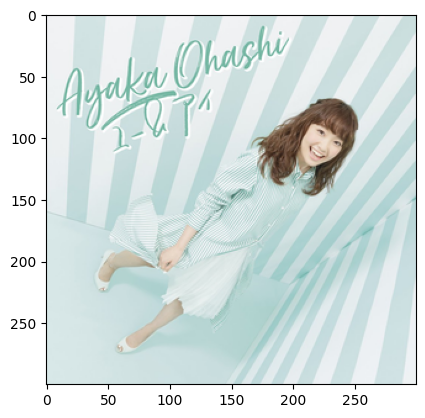

In [23]:
plt.imshow(photo)

Исходное изображение по данному индексу

In [24]:
genre_id

0

Выведен индекс жанра

In [25]:
lbl

'anime'

Лейбл соответствующего индекса жанра

Данные примеры говорят о том, что класс для загрузки данных работает правильно. Преобразование в тензор и предобработка изображений также произведена

Разбиение датасета на train и test:

In [26]:
total_len = len(dataset)

In [27]:
train_size = int(total_len * 0.8)
test_size = total_len - train_size

In [28]:
train_data, test_data = random_split(dataset, [train_size, test_size])

In [42]:
batch_size = 128

train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    drop_last=True)
test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4)

* Устанавливаем размер батча = 128. Большой размер батча поможет ускорить обучение

* `shuffle=True` для обучающего загрузчика гарантирует, что порядок образцов в каждой эпохе будет случайным

* `num_workers=4` - чисто параллельных процессов обработки данных

* `drop_last=True` последний неполный батч для гарантии одинакового размера всех батчей


Убедимся, что картинки на выходе имеют среднее от -1 до 1 и стандартное отклонение в пределах около 1:

In [45]:
img.mean([1, 2])

tensor([1.1621, 1.5775, 1.7688])

In [46]:
img.std([1, 2])

tensor([0.9502, 1.0260, 1.0521])

Данные хорошо центрированы после нормализации, что полезно для обучения нейронной сети, так как модели легче учиться на данных, центрированных вокруг нуля.

Средние значения в данном случае достаточно близки к верхней границе диапазона, но они всё же находятся внутри него, что хорошо.

Есть предпосылки для хорошего обучения нейронной сети.

## Выбор метрики

Выбрана метрика `Аccuracy` для оценки производительности нейронной сети для классификации жанров альбомов, так как она предоставляет простую и наглядную меру того, как часто модель правильно идентифицирует жанр на основе обложки альбома. Это позволяет быстро оценить, насколько эффективно модель справляется со своей задачей в условиях, когда все классификации имеют равное значение для данного проекта.

Несмотря на небольшой дисбаланс классов, Аccuracy даст хорошее представление о том, насколько эффективно модель справляется с задачей в целом.

## Обучение нейронной сети

In [48]:
class CoverNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_part = nn.Sequential(
        # Block 0
        nn.Conv2d(3, 16, 7, stride=2, padding=3),
        nn.BatchNorm2d(16),
        nn.LeakyReLU(0.5),

        # Block 1
        nn.Conv2d(16, 16, 3, padding=1),
        nn.BatchNorm2d(16),
        nn.LeakyReLU(0.5),

        nn.Conv2d(16, 32, 3, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(),

        nn.MaxPool2d(2),
        # Block 2
        nn.Conv2d(32, 32, 3, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.5),

        nn.Conv2d(32, 64, 3, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.5),

        nn.MaxPool2d(2),
        # Block 3
        nn.Conv2d(64, 64, 3, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.5),

        nn.Conv2d(64, 128, 3, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.5),

        nn.MaxPool2d(2),
        # Block 4
        nn.Conv2d(128, 128, 3, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.5),
        nn.Conv2d(128, 256, 3, padding=1),
        nn.LeakyReLU(0.5),
    )

    self.classifier = nn.Linear(256, 10)

  def forward(self, x):
    x = self.conv_part(x)
    x = x.mean(-1).mean(-1) # Global Average Pooling
    x = self.classifier(x)
    # x = F.softmax(x, dim=1)
    return x



* Каждый блок модели включает в себя два сверточных слоя `Conv2d`, благодаря чему модель улавливает не только простые линейные зависимости, но и более сложные нелинейные взаимосвязи. Это углубление поможет точнее распознавать разные сложные визуальные паттерны, характерные для разных музыкальных жанров.

* Слой `нормализации` после каждой свертки помогает ускорить обучение и делает модель менее чувствительной к масштабу входных данных

* `LeakyReLU` добавляет дополнительную нелинейность, повышая способность модели к обобщению.

* Слои пулинга сокращают размерность данных, уменьшая вычислительные затраты и делая обработку лучше.

* Классификационный слой в конце превращает обработанные данные в конкретные предсказания жанра. С `Global Average Pooling`  последний слой модели становится менее затратным с точки зрения вычислений и памяти.

Обучение и тестирование нейронной сети:

In [ ]:
net = CoverNet()
net = net.cuda()
net = net.eval()

optimizer = torch.optim.AdamW(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_loss = []
test_loss = []

train_acc = []
test_acc = []

for epoch in range(100):  # loop over the dataset multiple times
    print("Epoch", epoch)

    n_correct = 0
    n_total = 0

    loss_total = 0

    for data in (pbar := tqdm(train_loader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, _ = data

        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        net.train()
        outputs = net.forward(inputs)
        net.eval()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        pred_classes = outputs.argmax(dim=1)

        n_correct += (pred_classes.flatten() == labels.flatten()).float().sum().item()
        n_total += len(labels)

        loss_total += loss.item() * len(labels)

        pbar.set_description('Loss: {:.3f}({:.3f})'.format(loss_total / n_total, loss.item()) + ' Acc: {:.3f}'.format(n_correct/n_total))

    train_loss.append(loss_total / n_total)
    train_acc.append(n_correct / n_total)

    n_correct = 0
    n_total = 0

    loss_total = 0

    with torch.no_grad():
        for inputs, labels, _ in tqdm(test_loader, desc="Testing"):

            inputs, labels = inputs.cuda(), labels.cuda()

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            pred_classes = outputs.argmax(dim=1)

            n_correct += (pred_classes == labels).sum().item()
            n_total += len(labels)

            loss_total += loss.item() * len(labels)

    test_loss.append(loss_total / n_total)
    test_acc.append(n_correct / n_total)

    # Вывод результатов после каждой эпохи
    print(f"Epoch {epoch + 1}/{100} - Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Test Loss: {test_loss[-1]:.4f}, Test Acc: {test_acc[-1]:.4f}")
    torch.save(net.state_dict(), '/content/drive/MyDrive/epoch_' + str(epoch) + '_acc_' + str(test_acc[-1]))
print('Finished Training')

Epoch 0


Testing: 100%|██████████| 13/13 [00:13<00:00,  1.06s/it]


Epoch 1/100 - Train Loss: 2.1123, Train Acc: 0.2593, Test Loss: 2.3058, Test Acc: 0.1891
Epoch 1


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 2/100 - Train Loss: 1.9923, Train Acc: 0.3047, Test Loss: 2.0539, Test Acc: 0.2795
Epoch 2


Testing: 100%|██████████| 13/13 [00:14<00:00,  1.10s/it]


Epoch 3/100 - Train Loss: 1.9072, Train Acc: 0.3390, Test Loss: 1.9023, Test Acc: 0.3538
Epoch 3


Testing: 100%|██████████| 13/13 [00:14<00:00,  1.13s/it]


Epoch 4/100 - Train Loss: 1.8412, Train Acc: 0.3646, Test Loss: 1.8078, Test Acc: 0.3737
Epoch 4


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.00it/s]


Epoch 5/100 - Train Loss: 1.8003, Train Acc: 0.3786, Test Loss: 1.8103, Test Acc: 0.3904
Epoch 5


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


Epoch 6/100 - Train Loss: 1.8044, Train Acc: 0.3745, Test Loss: 1.7556, Test Acc: 0.4013
Epoch 6


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


Epoch 7/100 - Train Loss: 1.7691, Train Acc: 0.3932, Test Loss: 1.7764, Test Acc: 0.3981
Epoch 7


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 8/100 - Train Loss: 1.7371, Train Acc: 0.4002, Test Loss: 2.0058, Test Acc: 0.3218
Epoch 8


Testing: 100%|██████████| 13/13 [00:11<00:00,  1.09it/s]


Epoch 9/100 - Train Loss: 1.7245, Train Acc: 0.4049, Test Loss: 1.7153, Test Acc: 0.4160
Epoch 9


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 10/100 - Train Loss: 1.7043, Train Acc: 0.4139, Test Loss: 1.8850, Test Acc: 0.3590
Epoch 10


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]


Epoch 11/100 - Train Loss: 1.7026, Train Acc: 0.4186, Test Loss: 1.7147, Test Acc: 0.4026
Epoch 11


Testing: 100%|██████████| 13/13 [00:11<00:00,  1.10it/s]


Epoch 12/100 - Train Loss: 1.6855, Train Acc: 0.4212, Test Loss: 1.7449, Test Acc: 0.4096
Epoch 12


Testing: 100%|██████████| 13/13 [00:15<00:00,  1.17s/it]


Epoch 13/100 - Train Loss: 1.6824, Train Acc: 0.4201, Test Loss: 1.7174, Test Acc: 0.4135
Epoch 13


Testing: 100%|██████████| 13/13 [00:15<00:00,  1.18s/it]


Epoch 14/100 - Train Loss: 1.6458, Train Acc: 0.4259, Test Loss: 1.6672, Test Acc: 0.4269
Epoch 14


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]


Epoch 15/100 - Train Loss: 1.6419, Train Acc: 0.4367, Test Loss: 1.7755, Test Acc: 0.3679
Epoch 15


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 16/100 - Train Loss: 1.6318, Train Acc: 0.4351, Test Loss: 1.6413, Test Acc: 0.4449
Epoch 16


Testing: 100%|██████████| 13/13 [00:11<00:00,  1.09it/s]


Epoch 17/100 - Train Loss: 1.6283, Train Acc: 0.4414, Test Loss: 1.8098, Test Acc: 0.4038
Epoch 17


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 18/100 - Train Loss: 1.6086, Train Acc: 0.4421, Test Loss: 1.7272, Test Acc: 0.4122
Epoch 18


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 19/100 - Train Loss: 1.6049, Train Acc: 0.4409, Test Loss: 1.8163, Test Acc: 0.4083
Epoch 19


Testing: 100%|██████████| 13/13 [00:11<00:00,  1.11it/s]


Epoch 20/100 - Train Loss: 1.5879, Train Acc: 0.4494, Test Loss: 1.7247, Test Acc: 0.3904
Epoch 20


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 21/100 - Train Loss: 1.5735, Train Acc: 0.4484, Test Loss: 1.6925, Test Acc: 0.4167
Epoch 21


Testing: 100%|██████████| 13/13 [00:16<00:00,  1.25s/it]


Epoch 22/100 - Train Loss: 1.5651, Train Acc: 0.4583, Test Loss: 1.6057, Test Acc: 0.4468
Epoch 22


Testing: 100%|██████████| 13/13 [00:11<00:00,  1.16it/s]


Epoch 23/100 - Train Loss: 1.5502, Train Acc: 0.4634, Test Loss: 1.6501, Test Acc: 0.4192
Epoch 23


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 24/100 - Train Loss: 1.5368, Train Acc: 0.4631, Test Loss: 1.6234, Test Acc: 0.4526
Epoch 24


Testing: 100%|██████████| 13/13 [00:11<00:00,  1.14it/s]


Epoch 25/100 - Train Loss: 1.5382, Train Acc: 0.4639, Test Loss: 1.6908, Test Acc: 0.4462
Epoch 25


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]


Epoch 26/100 - Train Loss: 1.5217, Train Acc: 0.4749, Test Loss: 1.6614, Test Acc: 0.4340
Epoch 26


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 27/100 - Train Loss: 1.5258, Train Acc: 0.4744, Test Loss: 1.6203, Test Acc: 0.4404
Epoch 27


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 28/100 - Train Loss: 1.5001, Train Acc: 0.4854, Test Loss: 1.5916, Test Acc: 0.4564
Epoch 28


Testing: 100%|██████████| 13/13 [00:14<00:00,  1.12s/it]


Epoch 29/100 - Train Loss: 1.4983, Train Acc: 0.4805, Test Loss: 1.5999, Test Acc: 0.4558
Epoch 29


Testing: 100%|██████████| 13/13 [00:14<00:00,  1.11s/it]


Epoch 30/100 - Train Loss: 1.5118, Train Acc: 0.4816, Test Loss: 1.5432, Test Acc: 0.4564
Epoch 30


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]


Epoch 31/100 - Train Loss: 1.4829, Train Acc: 0.4871, Test Loss: 1.6308, Test Acc: 0.4429
Epoch 31


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 32/100 - Train Loss: 1.4793, Train Acc: 0.4845, Test Loss: 1.5922, Test Acc: 0.4494
Epoch 32


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 33/100 - Train Loss: 1.4862, Train Acc: 0.4844, Test Loss: 1.6028, Test Acc: 0.4442
Epoch 33


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


Epoch 34/100 - Train Loss: 1.4717, Train Acc: 0.4919, Test Loss: 1.6720, Test Acc: 0.4468
Epoch 34


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


Epoch 35/100 - Train Loss: 1.4632, Train Acc: 0.4982, Test Loss: 1.5709, Test Acc: 0.4673
Epoch 35


Testing: 100%|██████████| 13/13 [00:13<00:00,  1.02s/it]


Epoch 36/100 - Train Loss: 1.4588, Train Acc: 0.4959, Test Loss: 1.7932, Test Acc: 0.4250
Epoch 36


Testing: 100%|██████████| 13/13 [00:14<00:00,  1.13s/it]


Epoch 37/100 - Train Loss: 1.4512, Train Acc: 0.4927, Test Loss: 1.6118, Test Acc: 0.4474
Epoch 37


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 38/100 - Train Loss: 1.4475, Train Acc: 0.5008, Test Loss: 1.6062, Test Acc: 0.4577
Epoch 38


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 39/100 - Train Loss: 1.4388, Train Acc: 0.5005, Test Loss: 1.5567, Test Acc: 0.4692
Epoch 39


Testing: 100%|██████████| 13/13 [00:11<00:00,  1.09it/s]


Epoch 40/100 - Train Loss: 1.4242, Train Acc: 0.5037, Test Loss: 1.5584, Test Acc: 0.4635
Epoch 40


Testing: 100%|██████████| 13/13 [00:11<00:00,  1.09it/s]


Epoch 41/100 - Train Loss: 1.4402, Train Acc: 0.5003, Test Loss: 1.5146, Test Acc: 0.4885
Epoch 41


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 42/100 - Train Loss: 1.4279, Train Acc: 0.5054, Test Loss: 1.6752, Test Acc: 0.4205
Epoch 42


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 43/100 - Train Loss: 1.4105, Train Acc: 0.5140, Test Loss: 1.5518, Test Acc: 0.4583
Epoch 43


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]


Epoch 44/100 - Train Loss: 1.4142, Train Acc: 0.5039, Test Loss: 1.6097, Test Acc: 0.4545
Epoch 44


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.08it/s]


Epoch 45/100 - Train Loss: 1.3910, Train Acc: 0.5158, Test Loss: 1.5450, Test Acc: 0.4679
Epoch 45


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 46/100 - Train Loss: 1.4087, Train Acc: 0.5138, Test Loss: 1.5224, Test Acc: 0.4827
Epoch 46


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 47/100 - Train Loss: 1.3896, Train Acc: 0.5212, Test Loss: 1.5526, Test Acc: 0.4731
Epoch 47


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 48/100 - Train Loss: 1.3834, Train Acc: 0.5195, Test Loss: 1.5489, Test Acc: 0.4603
Epoch 48


Testing: 100%|██████████| 13/13 [00:10<00:00,  1.18it/s]


Epoch 49/100 - Train Loss: 1.3906, Train Acc: 0.5241, Test Loss: 1.6103, Test Acc: 0.4397
Epoch 49


Testing: 100%|██████████| 13/13 [00:14<00:00,  1.10s/it]


Epoch 50/100 - Train Loss: 1.3721, Train Acc: 0.5283, Test Loss: 1.6335, Test Acc: 0.4571
Epoch 50


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 51/100 - Train Loss: 1.3642, Train Acc: 0.5223, Test Loss: 1.5170, Test Acc: 0.4833
Epoch 51


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 52/100 - Train Loss: 1.3630, Train Acc: 0.5257, Test Loss: 1.6339, Test Acc: 0.4622
Epoch 52


Testing: 100%|██████████| 13/13 [00:13<00:00,  1.06s/it]


Epoch 53/100 - Train Loss: 1.3667, Train Acc: 0.5265, Test Loss: 1.8276, Test Acc: 0.4038
Epoch 53


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


Epoch 54/100 - Train Loss: 1.3656, Train Acc: 0.5259, Test Loss: 1.5772, Test Acc: 0.4731
Epoch 54


Testing: 100%|██████████| 13/13 [00:14<00:00,  1.10s/it]


Epoch 55/100 - Train Loss: 1.3382, Train Acc: 0.5355, Test Loss: 1.4814, Test Acc: 0.5038
Epoch 55


Testing: 100%|██████████| 13/13 [00:14<00:00,  1.09s/it]


Epoch 56/100 - Train Loss: 1.3379, Train Acc: 0.5376, Test Loss: 1.6288, Test Acc: 0.4622
Epoch 56


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.08it/s]


Epoch 57/100 - Train Loss: 1.3256, Train Acc: 0.5400, Test Loss: 1.5270, Test Acc: 0.4795
Epoch 57


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 58/100 - Train Loss: 1.3270, Train Acc: 0.5384, Test Loss: 1.6966, Test Acc: 0.4571
Epoch 58


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


Epoch 59/100 - Train Loss: 1.3218, Train Acc: 0.5405, Test Loss: 1.6746, Test Acc: 0.4455
Epoch 59


Testing: 100%|██████████| 13/13 [00:11<00:00,  1.17it/s]


Epoch 60/100 - Train Loss: 1.3084, Train Acc: 0.5441, Test Loss: 1.5168, Test Acc: 0.4904
Epoch 60


Testing: 100%|██████████| 13/13 [00:13<00:00,  1.05s/it]


Epoch 61/100 - Train Loss: 1.3104, Train Acc: 0.5462, Test Loss: 1.5436, Test Acc: 0.4859
Epoch 61


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


Epoch 62/100 - Train Loss: 1.3122, Train Acc: 0.5423, Test Loss: 1.5121, Test Acc: 0.4942
Epoch 62


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


Epoch 63/100 - Train Loss: 1.3104, Train Acc: 0.5477, Test Loss: 1.5351, Test Acc: 0.4865
Epoch 63


Testing: 100%|██████████| 13/13 [00:11<00:00,  1.09it/s]


Epoch 64/100 - Train Loss: 1.2870, Train Acc: 0.5545, Test Loss: 1.5004, Test Acc: 0.4891
Epoch 64


Testing: 100%|██████████| 13/13 [00:13<00:00,  1.00s/it]


Epoch 65/100 - Train Loss: 1.2792, Train Acc: 0.5552, Test Loss: 1.5793, Test Acc: 0.4718
Epoch 65


Testing: 100%|██████████| 13/13 [00:13<00:00,  1.00s/it]


Epoch 66/100 - Train Loss: 1.2731, Train Acc: 0.5552, Test Loss: 1.5302, Test Acc: 0.5013
Epoch 66


Testing: 100%|██████████| 13/13 [00:11<00:00,  1.10it/s]


Epoch 67/100 - Train Loss: 1.2587, Train Acc: 0.5632, Test Loss: 1.5895, Test Acc: 0.4917
Epoch 67


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


Epoch 68/100 - Train Loss: 1.2753, Train Acc: 0.5586, Test Loss: 1.7785, Test Acc: 0.4224
Epoch 68


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 69/100 - Train Loss: 1.2651, Train Acc: 0.5607, Test Loss: 1.6325, Test Acc: 0.4859
Epoch 69


Testing: 100%|██████████| 13/13 [00:11<00:00,  1.14it/s]


Epoch 70/100 - Train Loss: 1.2734, Train Acc: 0.5500, Test Loss: 1.5868, Test Acc: 0.4769
Epoch 70


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 71/100 - Train Loss: 1.2604, Train Acc: 0.5539, Test Loss: 1.5693, Test Acc: 0.4955
Epoch 71


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 72/100 - Train Loss: 1.2383, Train Acc: 0.5708, Test Loss: 1.5762, Test Acc: 0.4949
Epoch 72


Testing: 100%|██████████| 13/13 [00:11<00:00,  1.09it/s]


Epoch 73/100 - Train Loss: 1.2443, Train Acc: 0.5664, Test Loss: 1.6398, Test Acc: 0.4679
Epoch 73


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


Epoch 74/100 - Train Loss: 1.2326, Train Acc: 0.5726, Test Loss: 1.5786, Test Acc: 0.4846
Epoch 74


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 75/100 - Train Loss: 1.2256, Train Acc: 0.5706, Test Loss: 1.5577, Test Acc: 0.4833
Epoch 75


Testing: 100%|██████████| 13/13 [00:11<00:00,  1.16it/s]


Epoch 76/100 - Train Loss: 1.2139, Train Acc: 0.5752, Test Loss: 1.5854, Test Acc: 0.4814
Epoch 76


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


Epoch 77/100 - Train Loss: 1.2087, Train Acc: 0.5768, Test Loss: 1.6279, Test Acc: 0.4724
Epoch 77


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


Epoch 78/100 - Train Loss: 1.2012, Train Acc: 0.5864, Test Loss: 1.5602, Test Acc: 0.4910
Epoch 78


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]


Epoch 79/100 - Train Loss: 1.1965, Train Acc: 0.5794, Test Loss: 1.5643, Test Acc: 0.4910
Epoch 79


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


Epoch 80/100 - Train Loss: 1.2093, Train Acc: 0.5785, Test Loss: 1.5941, Test Acc: 0.4846
Epoch 80


Testing: 100%|██████████| 13/13 [00:14<00:00,  1.15s/it]


Epoch 81/100 - Train Loss: 1.1971, Train Acc: 0.5799, Test Loss: 1.6901, Test Acc: 0.4679
Epoch 81


Testing: 100%|██████████| 13/13 [00:11<00:00,  1.10it/s]


Epoch 82/100 - Train Loss: 1.1950, Train Acc: 0.5856, Test Loss: 1.5805, Test Acc: 0.4942
Epoch 82


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 83/100 - Train Loss: 1.1700, Train Acc: 0.5959, Test Loss: 1.5453, Test Acc: 0.5115
Epoch 83


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 84/100 - Train Loss: 1.1788, Train Acc: 0.5905, Test Loss: 1.7425, Test Acc: 0.4590
Epoch 84


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 85/100 - Train Loss: 1.1878, Train Acc: 0.5819, Test Loss: 1.7506, Test Acc: 0.4301
Epoch 85


Testing: 100%|██████████| 13/13 [00:15<00:00,  1.18s/it]


Epoch 86/100 - Train Loss: 1.1711, Train Acc: 0.5859, Test Loss: 1.6441, Test Acc: 0.4897
Epoch 86


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 87/100 - Train Loss: 1.1544, Train Acc: 0.6037, Test Loss: 1.5865, Test Acc: 0.4974
Epoch 87


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


Epoch 88/100 - Train Loss: 1.1574, Train Acc: 0.5951, Test Loss: 1.5693, Test Acc: 0.5090
Epoch 88


Testing: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


Epoch 89/100 - Train Loss: 1.1450, Train Acc: 0.6099, Test Loss: 1.5957, Test Acc: 0.4744
Epoch 89


Loss: 1.168(1.137) Acc: 0.590:   8%|▊         | 4/48 [00:05<00:40,  1.08it/s]

В коде настроено обучение и тестирование нейронной сети для классификации изображений:

* Используем оптимизатор `AdamW`, потому что он помогает модели быстро научиться различать изображения благодаря обновлению весов.

* `CrossEntropyLoss` - лосс-функция для задач многоклассовой классификации

* `100 эпох` дает модели достаточно времени и данных для хорошего обучения

Наибольшая точность на тесте и минимальные потери были достигнуты на **Epoch 83** с **Test Accuracy**: *0.5115* и **Test Loss**: *1.5453*.

## Вывод

Модель становится лучше с каждой эпохой, потому что точность растет как на тренировочных, так и на тестовых данных. Обе тренировочная и тестовая точность модели постепенно увеличиваются, что указывает на эффективность процесса обучения. Это видно из увеличения тренировочной точности с 0.2593 в первой эпохе до 0.6099 к 89 эпохе. Тестовая точность также увеличилась с 0.1891 до 0.4744 за аналогичный период.

Происходит уменьшение функции потерь как на тренировочном, так и на тестовом датасетах. Значит, модель хорошо справляется с задачей минимизации функции потерь, и происходит улучшение качества прогнозов.

Однако, модель все же работает лучше на тренировочных данных, чем на тестовых, что может указывать на переобучение. Тренировочная точность растет быстрее и достигает более высоких значений, чем тестовая точность. К примеру, тренировочная точность достигает 0.6099, тогда как тестовая точность составляет 0.4744 к 89 эпохе (Имеющиеся ресурсы CPU не позволили продолжить дальнейшее обучение эпох).

Также есть колебания в потерях и точности на тестовой выборке, что говорит о необходимости дальнейшей настройки параметров обучения, таких как `learning rate` и прочих параметров сети.


**Дальнейшая работа:**

* Использование техники регуляризации `dropout`, более тщательная настройка `learning rate`

* Использование других оптимизаторов

* Использование механизм ранней остановки для прекращения обучения, когда тестовая точность перестаёт улучшаться, чтобы избежать излишнего переобучения.